# Capstone Project 
## Part 1 - Predicting Airbnb rental prices

## Geographic data EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import pairwise
from sklearn.neighbors import DistanceMetric
from math import radians
from geopy import distance

%config InlineBackend.figure_format = 'retina'

%matplotlib inline

sns.set_theme(context='notebook', style='white', palette='deep', font_scale=1.5)

In [3]:
# load data
df = pd.read_csv('../GA/capstone-data-airbnb/dec20-data/active_listings_geo.csv', index_col=0)
df.shape

(20994, 5)

In [4]:
# load geographic data for neighbourhoods
df_areas = gpd.read_file('../GA/capstone-data-airbnb/neighbourhoods.geojson')
# drop null column
df_areas.drop(columns=['neighbourhood_group'], inplace=True)

### EDA by neighbourhood

In [6]:
df_agg = df.groupby('neighbourhood_cleansed').price.agg(['mean', 'median', 'count', 'std']).reset_index()
df_agg.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)
df_merged = pd.merge(df_areas, df_agg, on='neighbourhood', how='left')

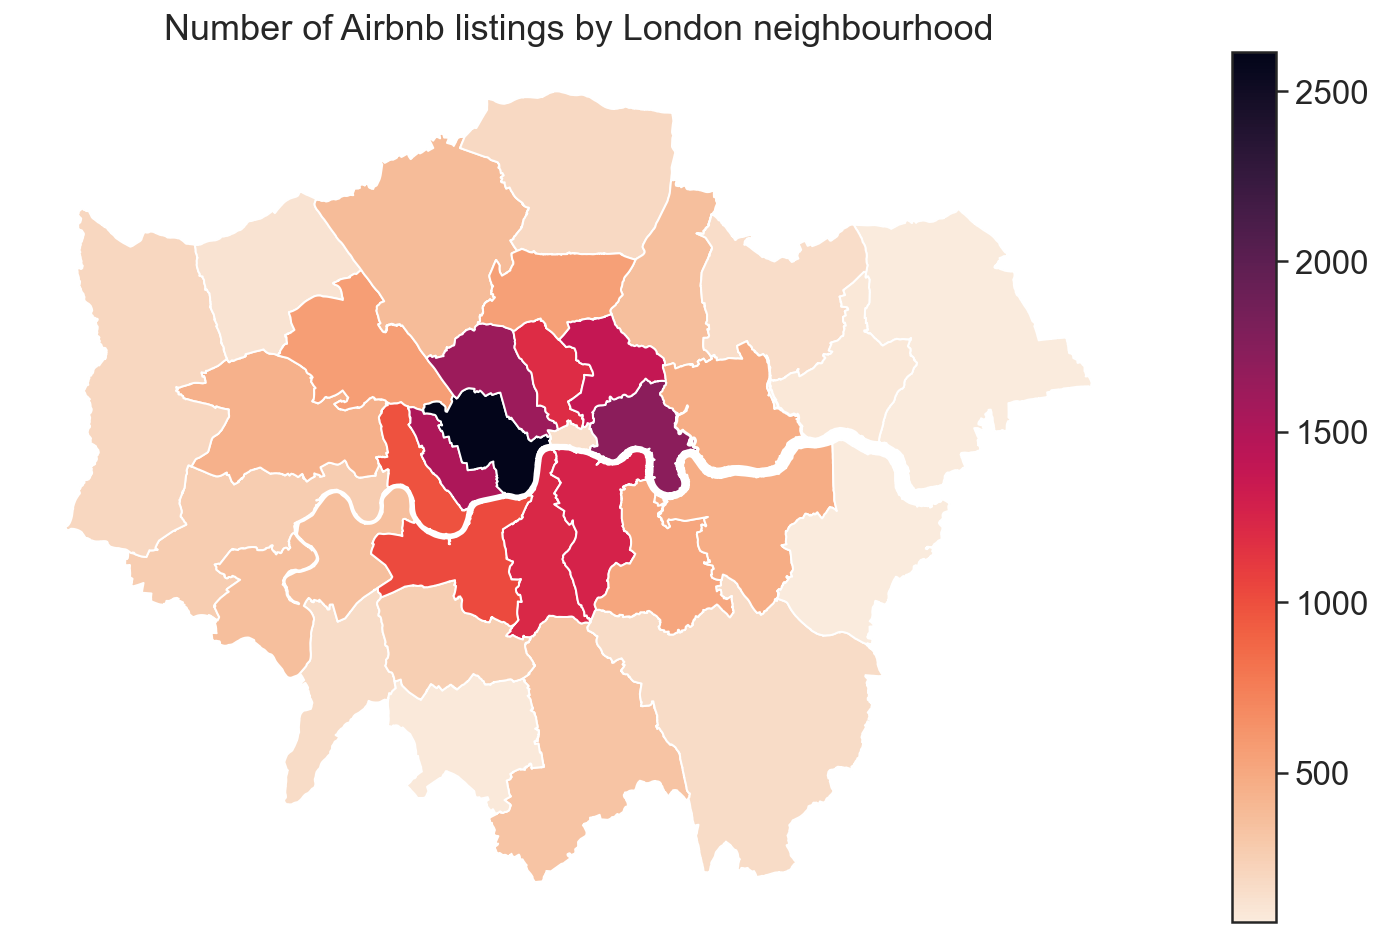

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
df_merged.plot(column='count', ax=ax, legend=True, cmap='rocket_r')
ax.set_title('Number of Airbnb listings by London neighbourhood', fontsize=18)
ax.axis('off')
plt.show()

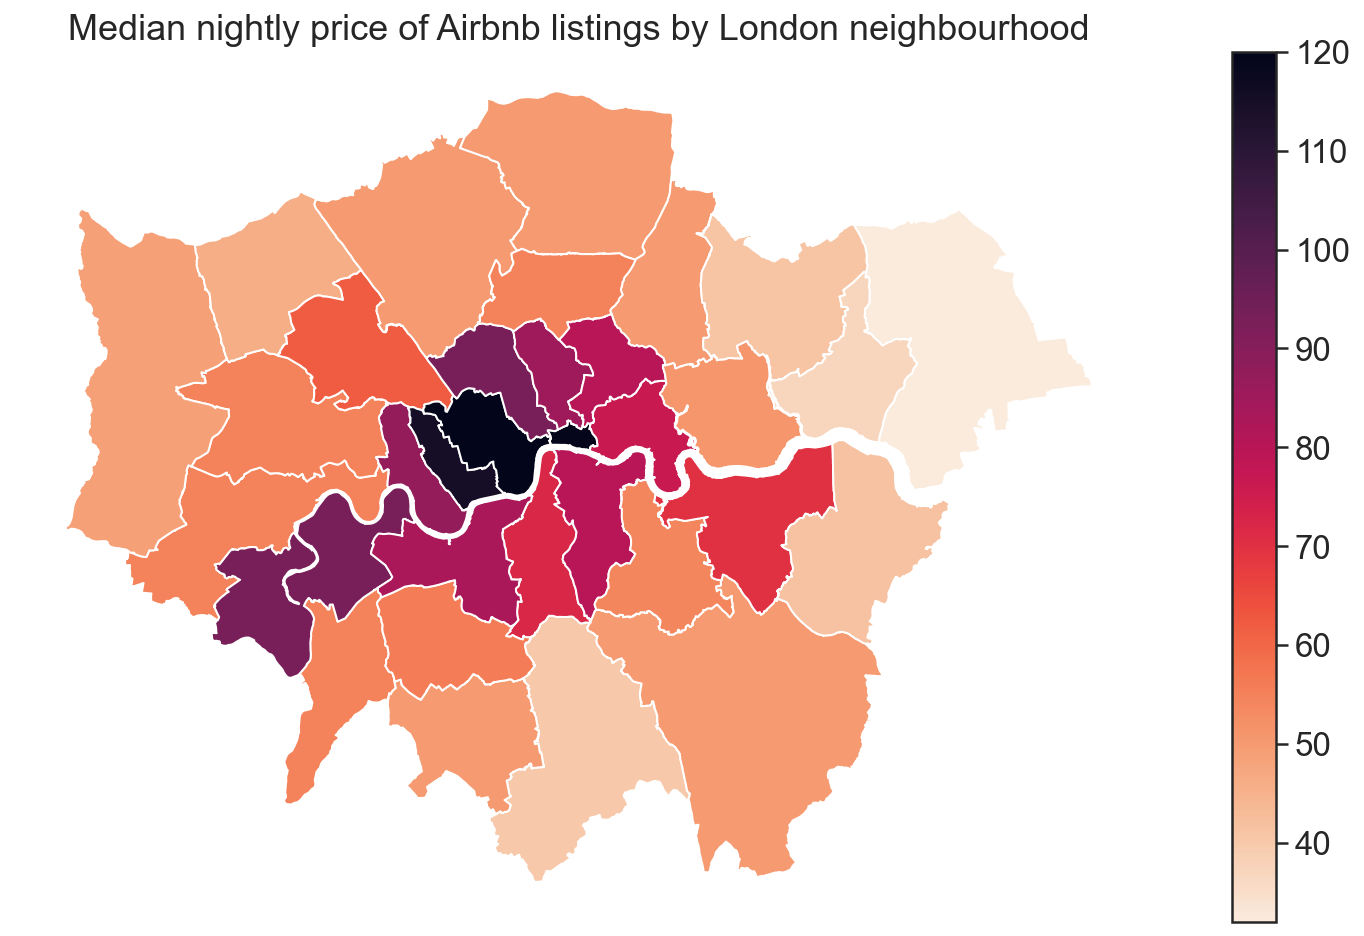

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
df_merged.plot(column='median', ax=ax, legend=True, cmap='rocket_r')
ax.set_title('Median nightly price of Airbnb listings by London neighbourhood', fontsize=18)
ax.axis('off')
plt.show()

### Feature engineering - tourist attractions
Top 12 visitor attractions in London by number of visits in 2019

In [10]:
# top 12 visitor attractions in London by number of visits in 2019
attractions = {'attraction': ['British Museum', 'Tate Modern', 'National Gallery', 'Natural History Museum', 'Southbank Centre',
                              'V&A Museum', 'Science Museum', 'Tower of London', 'Royal Museums Greenwich', 'Somerset House',
                              'Kew Gardens', 'Tate Britain'],
               'latitude': [51.51951341960992, 51.507650830446615, 51.508917759165875, 51.4965645731927,
                            51.50607709602179, 51.496619141481936, 51.49749392108883, 51.50811905720571,
                            51.476826250529264, 51.51109236570877, 51.478697005705655, 51.49104871919888],
               'longitude': [-0.12690295759810474, -0.0994581713692408, -0.12828495445604146, -0.17638866711822382,
                             -0.1162748246875384, -0.1721478152697852, -0.1745112632363688, -0.07608877663726685,
                             -0.0005002017768626309, -0.1171372729403201, -0.29558373061227466, -0.1277134999279927]}
df_attractions = pd.DataFrame(attractions)
gdf_attractions = gpd.GeoDataFrame(df_attractions, 
                                   geometry=gpd.points_from_xy(df_attractions.longitude, df_attractions.latitude))

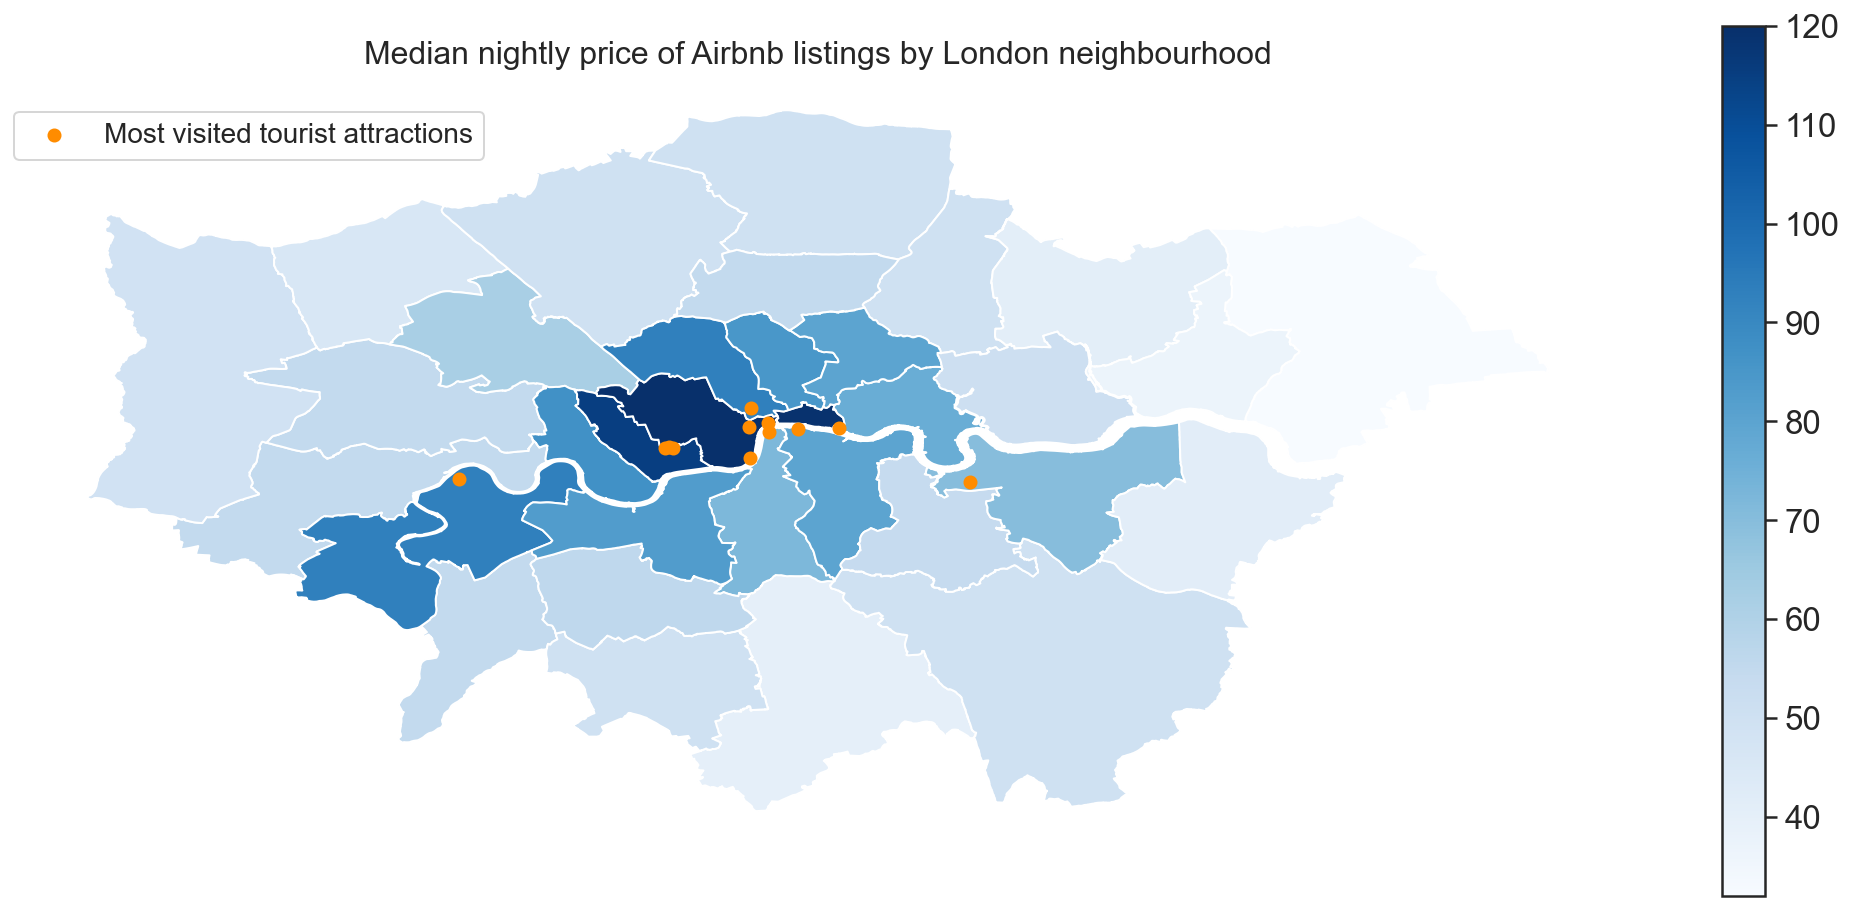

In [11]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.set_aspect('equal')
df_merged.plot(column='median', ax=ax, legend=True, cmap='Blues')
gdf_attractions.plot(ax=ax, marker='o', color='darkorange')
ax.legend(['Most visited tourist attractions'], loc=(0,0.89), fontsize=14)

ax.set_title('Median nightly price of Airbnb listings by London neighbourhood', fontsize=16)
ax.axis('off')

plt.show()

#### Different methods for calculating distance

In [12]:
# using sklearn
R = 6373
dist = DistanceMetric.get_metric('haversine')
lat1, lon1 = df.latitude[0], df.longitude[0]
lat2, lon2 = gdf_attractions.latitude[0], gdf_attractions.longitude[0]

A = [[radians(lat1), radians(lon1)], [radians(lat2), radians(lon2)]]
distance_sklearn = R * dist.pairwise(A)
print('distance using sklearn: ', np.array(distance_sklearn).item(1))

distance using sklearn:  6.4038841490450755


In [13]:
# using geopy
# default distance.distance uses Vincenty distance which uses a more accurate ellipsoidal model of the earth
distance_geopy = distance.distance([lat1, lon1], [lat2, lon2]).km
print('distance using geopy: ', distance_geopy)
    
distance_geopy_great_circle = distance.great_circle([lat1, lon1], [lat2, lon2]).km 
print('distance using geopy great circle: ', distance_geopy_great_circle)

distance using geopy:  6.405666199543955
distance using geopy great circle:  6.401883500474538


#### Calculate distance from each listing to each tourist attraction

In [14]:
def calculate_distance(df, i):
    lat1, lon1 = df['latitude'], df['longitude']
    lat2, lon2 = attractions['latitude'][i], attractions['longitude'][i]
    return distance.distance([lat1, lon1], [lat2, lon2]).km

In [15]:
for i, attraction in enumerate(attractions['attraction']):
    df[attraction] = df.apply(calculate_distance, i=i, axis=1)

In [18]:
df.head()

,id,price,neighbourhood_cleansed,longitude,latitude,British Museum,Tate Modern,National Gallery,Natural History Museum,Southbank Centre,V&A Museum,Science Museum,Tower of London,Royal Museums Greenwich,Somerset House,Kew Gardens,Tate Britain
0,11551,105.0,Lambeth,-0.11732,51.46225,6.405666,5.201338,5.247708,5.604892,4.876635,5.397220,5.582226,5.852026,8.277842,5.434098,12.521149,3.284432
2,15400,75.0,Kensington and Chelsea,-0.16898,51.48796,4.567264,5.301668,3.663750,1.086845,4.178438,0.988199,1.128143,6.829480,11.769198,4.425367,8.854811,2.886752
6,25123,29.0,Barnet,-0.20906,51.57224,8.178958,10.462463,9.002207,8.719396,9.779001,8.794683,8.654764,11.662043,17.950141,9.324912,12.015554,10.651903
8,36299,195.0,Richmond upon Thames,-0.28066,51.47934,11.574880,12.972732,11.082210,7.491807,11.797984,7.778431,7.644538,14.563807,19.465768,11.893075,1.039252,10.703690
14,38605,58.0,Hammersmith and Fulham,-0.23328,51.50687,7.517525,9.291585,7.293209,4.113439,8.124227,4.395428,4.211959,10.914532,16.509153,8.077098,5.343082,7.539129


In [19]:
# write data to CSV
df.to_csv('../GA/capstone-data-airbnb/dec20-data/active_listings_geo_clean.csv')